# Has Youtube had any effect on Wikipedia edits and views?

In [322]:
from datetime import datetime
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns_palette = "muted"

## Scraping Wikipedia

In [231]:
"""
Created on Wed Nov 28 12:13:22 2018
Example Wiki API calls
@author: Patrick Gildersleve
"""
import requests

def query(request): # query Wikipedia as a generator function
    request['action'] = 'query'
    request['format'] = 'json'
    lastContinue = {}
    while True:
        # Clone original request
        req = request.copy()
        # Modify it with the values returned in the 'continue' section of the last result.
        req.update(lastContinue)
        # Call API
        result = requests.get('https://en.wikipedia.org/w/api.php', params=req).json()
        if 'error' in result:
            print(result['error'])
            #raise Error(result['error'])
        if 'warnings' in result:
            print(result['warnings'])
        if 'query' in result:
            yield result['query']
        if 'continue' not in result:
            break
        lastContinue = result['continue']

Scraping edits of all Youtube pages for 2018

Two types of baselines:
* Same pages but for 2017
* Other conspiracy theory pages that have not yet been linked and compare for 2018

Merge with clickstream to compare traffic

In [762]:
#Defining youtube pages
youtube = ['Global warming',
           'Dulce Base',
           'Lilla Saltsjöbadsavtalet',
           '1980 Camarate air crash',
           'Federal Emergency Management Agency',
           'Kecksburg UFO incident',
           'MMR vaccine']

#create dataframe to populate with edits
df_youtube = pd.DataFrame(columns=['pagename','pageid','timestamp','revisionID'])

#loop through the search terms
for conspiracy in youtube:
    #get data from 2017-18
    revisionsparams = {'titles':conspiracy, 'prop':'revisions', 'rvprop':'timestamp|user', 'rvend':'2017-01-01T00:00:00Z', 'rvslots':'main', 'formatversion':'2'}
    revisionsdata = list(query(revisionsparams))
    pagename = conspiracy
    for c,item in enumerate(revisionsdata):
        revision_id = c
        for revisions in item['pages']:
            pageid = revisions['pageid']
            for r in revisions['revisions']:
                df = pd.DataFrame([[pagename,pageid,r['timestamp'],revision_id]],columns = ['pagename','pageid','timestamp','revisionID'])
                df_youtube = df_youtube.append(df)
    print(conspiracy,'- completed')

Global warming - completed
Dulce Base - completed
Lilla Saltsjöbadsavtalet - completed
1980 Camarate air crash - completed
Federal Emergency Management Agency - completed
Kecksburg UFO incident - completed
MMR vaccine - completed


In [763]:
#check how many edits for each
df_youtube['pagename'].value_counts()

Global warming                         729
Federal Emergency Management Agency    150
MMR vaccine                            150
Kecksburg UFO incident                  96
Dulce Base                              72
Lilla Saltsjöbadsavtalet                13
1980 Camarate air crash                  5
Name: pagename, dtype: int64

In [764]:
#convert dates
df_youtube['date'] = df_youtube['timestamp'].apply(lambda x: datetime.strptime(x[:x.find('T')], '%Y-%m-%d'))
df_youtube['day'] = df_youtube['date'].dt.day
df_youtube['month'] = df_youtube['date'].dt.month
df_youtube['year'] = df_youtube['date'].dt.year
df_youtube['week'] = df_youtube['date'].dt.week

In [765]:
pd.crosstab(df_youtube['pagename'], df_youtube['year'],margins=True).sort_values('All', ascending = False)
# df2.pivot_table(values='X', rows='Y', cols='Z',
#                          aggfunc=lambda x: len(x.unique()))

year,2017,2018,2019,All
pagename,,,,
All,487,716,12,1215
Global warming,289,428,12,729
Federal Emergency Management Agency,86,64,0,150
MMR vaccine,49,101,0,150
Kecksburg UFO incident,24,72,0,96
Dulce Base,31,41,0,72
Lilla Saltsjöbadsavtalet,6,7,0,13
1980 Camarate air crash,2,3,0,5


In [766]:
df_youtube = df_youtube[df_youtube['year']!=2019]

## Comparing 2017 to 2018 edits

In [342]:
def month_year(x):
    return datetime(x[0],x[1],1)


df_youtube = df_youtube.reset_index().drop(columns='index')
df_youtube['type'] = 'treatment'
data = df_youtube['revisionID'].groupby([df_youtube['month'],df_youtube['year']]).count().reset_index()
data['m_y'] = data[['year','month']].apply(month_year, axis = 1)

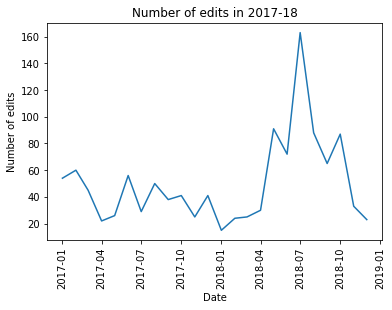

In [327]:
ax = sns.lineplot(x="m_y", y = 'revisionID', data=data, palette = sns.color_palette(sns_palette, n_colors = 1))
plt.xlabel('Date')
plt.ylabel('Number of edits')
plt.xticks(rotation = 'vertical')
plt.title('Number of edits in 2017-18')
plt.show()

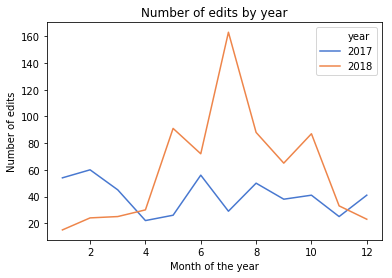

In [326]:
ax = sns.lineplot(x="month", y="revisionID", data=data, hue = 'year', palette = sns.color_palette(sns_palette, n_colors = 2))

plt.xlabel('Month of the year')
plt.ylabel('Number of edits')
plt.title('Number of edits by year')
plt.show()
#overall number of changes for all pages 

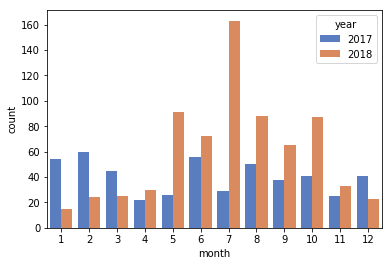

In [325]:
ax = sns.countplot(x="month", data=df_youtube, hue = 'year', palette = sns.color_palette(sns_palette, n_colors = 2))

In [664]:
youtube_pivot = df_youtube.pivot_table(index='pagename', 
                     columns=['year','month','type'], 
                     values='revisionID',
                     fill_value=0, 
                     aggfunc='count').unstack().reset_index()
youtube_pivot['m_y'] = youtube_pivot[['year','month']].apply(month_year, axis = 1)
youtube_pivot['type'] = 'treatment'
youtube_pivot = data_pivot.rename(columns = {0:'revision_count'})

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


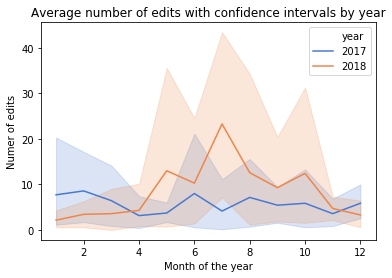

In [646]:
sns.lineplot(x="month", y="revision_count", data=youtube_pivot, hue = 'year', 
             palette = sns.color_palette(sns_palette, n_colors = len(set(youtube_pivot['year']))))

plt.xlabel('Month of the year')
plt.ylabel('Numer of edits')
plt.title('Average number of edits with confidence intervals by year')
plt.show()

We clearly see that there was an unusual spike in edits around the announcement date.

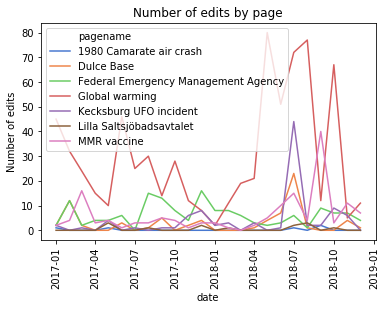

In [392]:
import seaborn as sns
ax = sns.lineplot(x="m_y", y="revision_count", data=youtube_pivot, hue = 'pagename', 
                  palette = sns.color_palette(sns_palette, n_colors = len(youtube)))

plt.xlabel('date')
plt.xticks(rotation = 'vertical')
plt.ylabel('Number of edits')
plt.title('Number of edits by page')
plt.show()

## Have other pages seen the same trend?
Let's take a random sample of pages that have conspiracy theories around them (based on https://en.wikipedia.org/wiki/List_of_conspiracy_theories). We take the actual page and not the conspiracy page to ensure it is like for like (Youtube links to the actual page)

Some of these have their own conspiracy page, other don't (check that's also the case for youtube pages)

Could find conspiracy theories like for like?

In [767]:
other_consp = ['Illuminati',
           'September 11 attacks',
           'Korean Air Lines Flight 007',
           'Freemasonry',
           'Roswell UFO incident',
           'Sandy Hook Elementary School shooting',
           'Water fluoridation']

df_other = pd.DataFrame(columns=['pagename','pageid','timestamp','revisionID'])
# timestamp , user name, a revision ID

for conspiracy in other_consp:
    
    revisionsparams = {'titles':conspiracy, 'prop':'revisions', 'rvprop':'timestamp|user', 'rvend':'2017-01-01T00:00:00Z', 'rvslots':'main', 'formatversion':'2'}
    revisionsdata = list(query(revisionsparams))
    pagename = conspiracy

    for c,item in enumerate(revisionsdata):
        revision_id = c
        for revisions in item['pages']:
            pageid = revisions['pageid']
            for r in revisions['revisions']:
                df = pd.DataFrame([[pagename,pageid,r['timestamp'],revision_id]],columns = ['pagename','pageid','timestamp','revisionID'])
                df_other = df_other.append(df)
    print(conspiracy, '- completed')
            

Illuminati - completed
September 11 attacks - completed
Korean Air Lines Flight 007 - completed
Freemasonry - completed
Roswell UFO incident - completed
Sandy Hook Elementary School shooting - completed
Water fluoridation - completed


In [768]:
print(df_other['pagename'].value_counts())

September 11 attacks                     601
Sandy Hook Elementary School shooting    566
Korean Air Lines Flight 007              267
Roswell UFO incident                     198
Freemasonry                              153
Illuminati                               105
Water fluoridation                       101
Name: pagename, dtype: int64


In [770]:
#convert dates
df_other['date'] = df_other['timestamp'].apply(lambda x: datetime.strptime(x[:x.find('T')], '%Y-%m-%d'))
df_other['day'] = df_other['date'].dt.day
df_other['month'] = df_other['date'].dt.month
df_other['year'] = df_other['date'].dt.year
df_other['week'] = df_other['date'].dt.week

In [771]:
df_youtube = df_youtube[df_youtube['year']!=2019]

In [654]:
#append both datasets
df_other['type'] = 'control'
wiki_data = pd.concat([df_other,df_youtube])

In [656]:
def month_year(x):
    return datetime(x[0],x[1],1)


wiki_data = wiki_data.reset_index().drop(columns='index')
wiki_data['m_y'] = wiki_data[['year','month']].apply(month_year, axis = 1)
data = wiki_data['revisionID'].groupby([wiki_data['m_y'],wiki_data['type']]).count().reset_index()


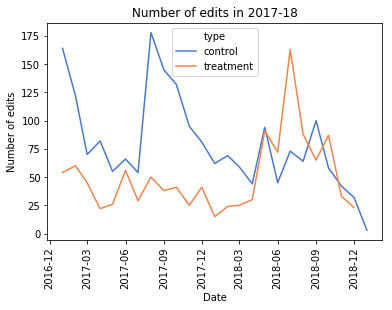

In [609]:
ax = sns.lineplot(x="m_y", y = 'revisionID', data=data, hue = 'type', palette = sns.color_palette(sns_palette, n_colors = 2))
plt.xlabel('Date')
plt.ylabel('Number of edits')
plt.xticks(rotation = 'vertical')
plt.title('Number of edits in 2017-18')
plt.savefig('img/edits.png')
plt.show()

Maybe these aren't comparable. that being said, we see a constant number for the others (no change) vs the youtube one

In [669]:
#have to pivot them separately to fill 0s or else it creates lines where a youtube is tagged as 'other' and vice versa
other_pivot = df_other.pivot_table(index='pagename', 
                     columns=['year','month','type'], 
                     values='revisionID',
                     fill_value=0, 
                     aggfunc='count').unstack().reset_index()
other_pivot['m_y'] = other_pivot[['year','month']].apply(month_year, axis = 1)
other_pivot = other_pivot.rename(columns = {0:'revision_count'})

wiki_pivot = pd.concat([other_pivot,youtube_pivot])

/Users/jlhc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


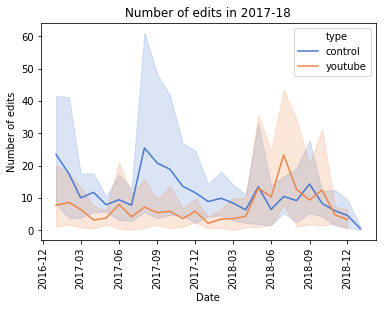

In [644]:
ax = sns.lineplot(x="m_y", y = 'revision_count', data=wiki_pivot, hue = 'type',
                  palette = sns.color_palette(sns_palette, n_colors = len(set(wiki_pivot['type']))))
plt.xlabel('Date')
plt.ylabel('Number of edits')
plt.xticks(rotation = 'vertical')
plt.title('Number of edits in 2017-18')
plt.show()

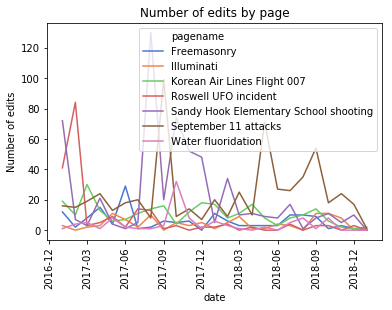

In [613]:

ax = sns.lineplot(x="m_y", y="revision_count", data=wiki_pivot[wiki_pivot['type']=='control'], hue = 'pagename'
                  ,palette = sns.color_palette(sns_palette, n_colors = len(other_consp)))

plt.xlabel('date')
plt.xticks(rotation = 'vertical')
plt.ylabel('Number of edits')
plt.title('Number of edits by page')
plt.show()

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


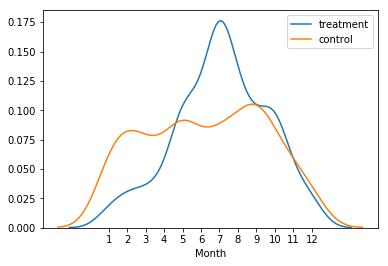

In [616]:
m = wiki_data['month'].unique()
m.sort()

sns.kdeplot(wiki_data[(wiki_data['type'] == 'treatment') & (wiki_data['year'] == 2018)]['month'],label='treatment')
sns.kdeplot(wiki_data[(wiki_data['type'] == 'control') & (wiki_data['year'] == 2018)]['month'],label='control')
plt.xticks(m)
plt.xlabel('Month')
plt.legend()

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


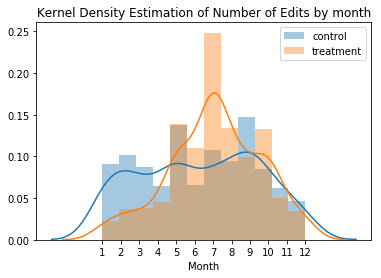

In [728]:
m = wiki_data['month'].unique()
m.sort()

sns.distplot(wiki_data[(wiki_data['type'] == 'control') & (wiki_data['year'] == 2018)]['month'],label='control',bins=12)
sns.distplot(wiki_data[(wiki_data['type'] == 'treatment') & (wiki_data['year'] == 2018)]['month'],label='treatment',bins=12)
plt.xticks(m)
plt.xlabel('Month')
plt.title('Kernel Density Estimation of Number of Edits by month')
plt.savefig('img/kde_edits.png')
plt.legend()

## Download clickstream data to look at traffic
https://dumps.wikimedia.org/other/clickstream/

In [528]:
import pandas as pd
import numpy as np
import math

conspiracies = youtube + other_consp
conspiracies = [mystring.replace(" ", "_") for mystring in conspiracies]
df_clickstream = pd.DataFrame(columns = ['prev','type','curr','n','month'])

#takes about 1 min to run (around 30m rows)
for m in ['01','02','03','04','05','06','07','08','09','10','11']: #12 not yet available
    data = pd.read_csv('clickstream_data/clickstream-enwiki-2018-%s.tsv'%m, sep='\t', header = None)
    data = data.rename(columns={0:'prev', 1:'curr', 2:'type', 3:'n'})
    df = data[data['curr'].isin(conspiracies)]
    df = df.groupby(['prev','type','curr']).sum().reset_index()
    df['month'] = m
    df_clickstream = df_clickstream.append(df)
    print('month %s completed'%m)

month 01 completed
month 02 completed
month 03 completed
month 04 completed
month 05 completed
month 06 completed
month 07 completed
month 08 completed
month 09 completed
month 10 completed
month 11 completed


In [529]:
#save so we don't have to run this again
df_clickstream.to_csv('clickstream_data/df_clickstream')

In [537]:
df_clickstream['prev'].value_counts().head(10)


other-empty                            154
other-search                           149
other-internal                         145
other-external                         138
Main_Page                              132
other-other                            112
List_of_conspiracy_theories             74
Conspiracy_theory                       64
Wiki                                    45
New_World_Order_(conspiracy_theory)     44
Name: prev, dtype: int64

In [538]:
df_clickstream['referer_type'] = df_clickstream['prev'].apply(
    lambda x: x if x in ['other-empty','other-search','other-internal','other-external','other-other'] else 'Wikipage') 

In [539]:
# pd.read_csv('clickstream_data/df_clickstream')
df_traffic = pd.pivot_table(df_clickstream, values = 'n', index = ['curr','month'], 
                            columns = 'referer_type', fill_value = 0, aggfunc = np.sum).reset_index()

In [541]:
df_traffic.head()

referer_type,curr,month,Wikipage,other-empty,other-external,other-internal,other-other,other-search
0,1980_Camarate_air_crash,01,84,142,0,0,0,44
1,1980_Camarate_air_crash,02,31,158,15,17,0,64
2,1980_Camarate_air_crash,03,86,120,12,18,0,58
3,1980_Camarate_air_crash,04,61,125,0,13,0,61
4,1980_Camarate_air_crash,05,47,95,0,15,0,50


In [619]:
'''
external: if the referer host is not en(.m)?.wikipedia.org
'''

df_traffic['total'] = df_traffic.iloc[:,2:].sum(axis=1)
df_traffic['pagename'] = [mystring.replace("_", " ") for mystring in df_traffic['curr']]
df_traffic['type'] = df_traffic['pagename'].apply(lambda x: 'treatment' if x in youtube else 'control')
df_traffic['month'] = df_traffic['month'].apply(lambda x: int(x))

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


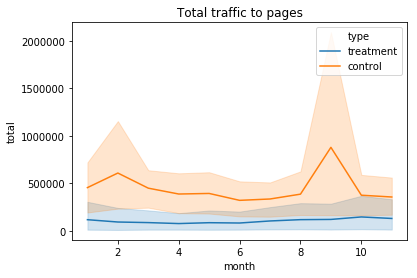

In [620]:
ax = sns.lineplot(x="month", y="total", data=df_traffic, hue = 'type')
plt.title('Total traffic to pages')
plt.show()

/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


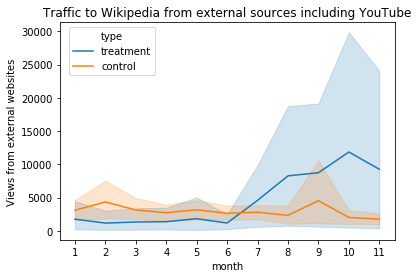

In [621]:
ax = sns.lineplot(x="month", y="other-external", data=df_traffic, hue = 'type')
plt.title('Traffic to Wikipedia from external sources including YouTube')
plt.xticks([n for n in range(1,12)])
plt.ylabel('Views from external websites')
plt.legend(bbox_to_anchor=(0.2, 0.5, 0.1, 0.5))
plt.savefig('img/ext_traffic.png')
plt.show()

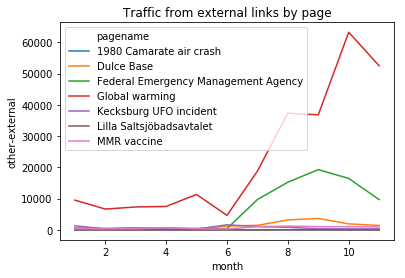

In [624]:
#look at individual?
ax = sns.lineplot(x="month", y="other-external", data=df_traffic[df_traffic['type']=='treatment'], hue = 'pagename')
plt.title('Traffic from external links by page')
plt.show()

In [748]:
#total lines?
data = df_traffic['other-external'].groupby([df_traffic['month'],df_traffic['type']]).sum().reset_index()

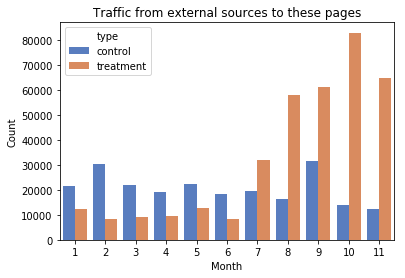

In [749]:
ax = sns.barplot(x="month", y = 'other-external', data=data, hue = 'type', palette = sns.color_palette(sns_palette, n_colors = 2))
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Traffic from external sources to these pages')
plt.savefig('img/ext_count.png')
plt.show()

# Merge data into one table

In [628]:
display(df_traffic.head())

referer_type,curr,month,Wikipage,other-empty,other-external,other-internal,other-other,other-search,total,pagename,type
0,1980_Camarate_air_crash,1,84,142,0,0,0,44,540,1980 Camarate air crash,treatment
1,1980_Camarate_air_crash,2,31,158,15,17,0,64,570,1980 Camarate air crash,treatment
2,1980_Camarate_air_crash,3,86,120,12,18,0,58,588,1980 Camarate air crash,treatment
3,1980_Camarate_air_crash,4,61,125,0,13,0,61,520,1980 Camarate air crash,treatment
4,1980_Camarate_air_crash,5,47,95,0,15,0,50,414,1980 Camarate air crash,treatment


In [678]:
wiki_pivot18 = wiki_pivot[wiki_pivot['year']==2018]

In [680]:
display(wiki_pivot18.head())

,m_y,month,pagename,revision_count,type,year
84,2018-01-01,1,Freemasonry,11,control,2018
85,2018-01-01,1,Illuminati,1,control,2018
86,2018-01-01,1,Korean Air Lines Flight 007,17,control,2018
87,2018-01-01,1,Roswell UFO incident,2,control,2018
88,2018-01-01,1,Sandy Hook Elementary School shooting,5,control,2018


In [681]:
'''
Merge the two pivot tables so that I get number of edits and traffic by month and page
We can then normalise by traffic:
If edits increase the same amount as other pages, we can just say it's due to increased interest in the page
If edits increases more than other pages, than it may mean different types of edits
This is not entirely robust as edits and views are not necessarily correlated. 
This does provide an indication that edits are of different nature
'''
pivot_merge = wiki_pivot18.merge(df_traffic.drop(columns = ['curr','type']), on = ['month','pagename'], how = 'left')
pivot_merge['revision_norm_total'] = pivot_merge['revision_count']/pivot_merge['total']

In [682]:
pivot_merge['revision_norm_external'] = pivot_merge['revision_count']/pivot_merge['other-external']


/Users/jlhc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


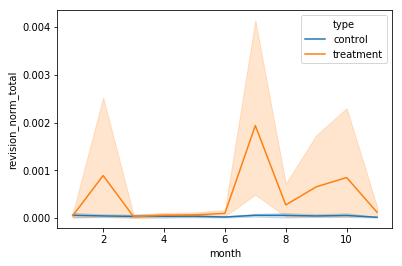

In [683]:
ax = sns.lineplot(x="month", y="revision_norm_total", data=pivot_merge, hue = 'type')


This normalised by page. That's a lot of noise. Let's group them together and get a total:


In [715]:
pivot_merge2 = pivot_merge.groupby([pivot_merge.month,pivot_merge.type]).sum().reset_index()

In [717]:
pivot_merge2 = pivot_merge2.drop(columns = ['revision_norm_total','revision_norm_external'])

In [718]:
pivot_merge2['revision_norm_total'] = pivot_merge2['revision_count']/pivot_merge2['total']

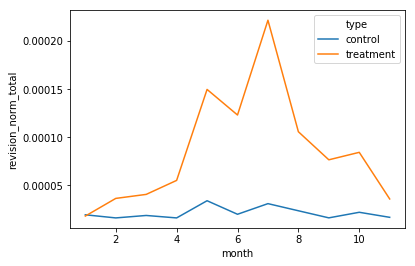

In [721]:
ax = sns.lineplot(x="month", y="revision_norm_total", data=pivot_merge2, hue = 'type')

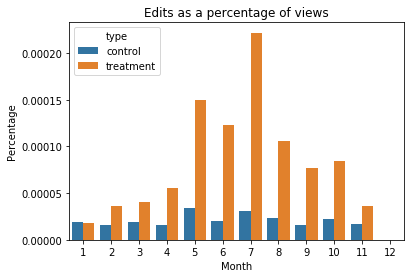

In [731]:
ax = sns.barplot(x="month", y="revision_norm_total", data=pivot_merge2, hue = 'type')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.yticks
plt.title('Edits as a percentage of views')
plt.savefig('img/norm_edits.png')
plt.show()


# Percentage increases

In [733]:
views_pct = df_traffic.groupby(['type','month']).sum()
# total_other = total[


In [742]:
views_pct['pct'] = views_pct['other-external'].pct_change()

In [744]:
views_pct = views_pct.reset_index()

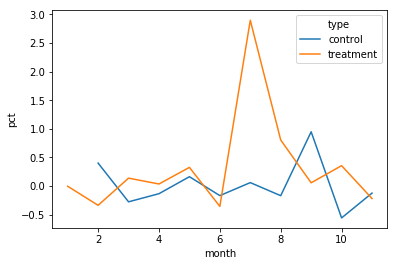

In [745]:
ax = sns.lineplot(x="month", y="pct", data=views_pct, hue = 'type')
#views seem to be linked to other events (e.g. 9/11 date. 
#What about sandy hook? it happened in december. maybe another shooting?)

In [746]:
views_pct

referer_type,type,month,Wikipage,other-empty,other-external,other-internal,other-other,other-search,total,pct
0,control,1,171207,370508,21679,26237,27,1005246,3189808,NaN
1,control,2,217911,466787,30375,30959,10,1385225,4262534,0.401126
2,control,3,187249,354183,22005,27513,28713,955027,3149380,-0.275556
3,control,4,191356,302871,19067,26126,25393,794323,2718272,-0.133515
4,control,5,207417,273527,22182,27392,26544,823084,2760292,0.163371
5,control,6,178971,221891,18482,22529,25140,659217,2252460,-0.166802
6,control,7,209105,229146,19594,23789,27811,666693,2352276,0.060167
7,control,8,227376,268990,16297,27598,31826,782288,2708750,-0.168266
8,control,9,337008,540539,31747,54469,50992,2062320,6154150,0.948027
9,control,10,217455,220386,14072,28151,11215,824042,2630642,-0.556746
